In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [5]:
image_path = "D:/Holland_Year_2\Block_B/2024-25b-fai2-adsai-PetarPaskalev232725/datalab_tasks/task3/task_3_image_1.png"

In [6]:
image = cv2.imread(image_path)

In [7]:
type(image)

numpy.ndarray

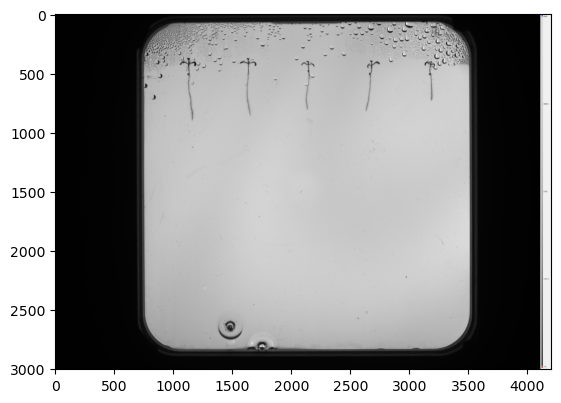

In [8]:
plt.imshow(image)

In [25]:
# Edge Detection Function
def detect_edges(image):
    """Detect edges to find the approximate square Petri dish."""
    # Apply Gaussian blur to smooth the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Compute horizontal and vertical gradients
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the gradient magnitude
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

    # Threshold to identify strong edges
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    # Find contours to identify the Petri dish
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest square-like contour is the Petri dish
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    return x, x + w, y, y + h


In [26]:
# Crop Image Function
def crop_image(image, edges):
    """Crop the image based on detected edges and return the cropped region."""
    left, right, top, bottom = edges
    return image[top:bottom, left:right]



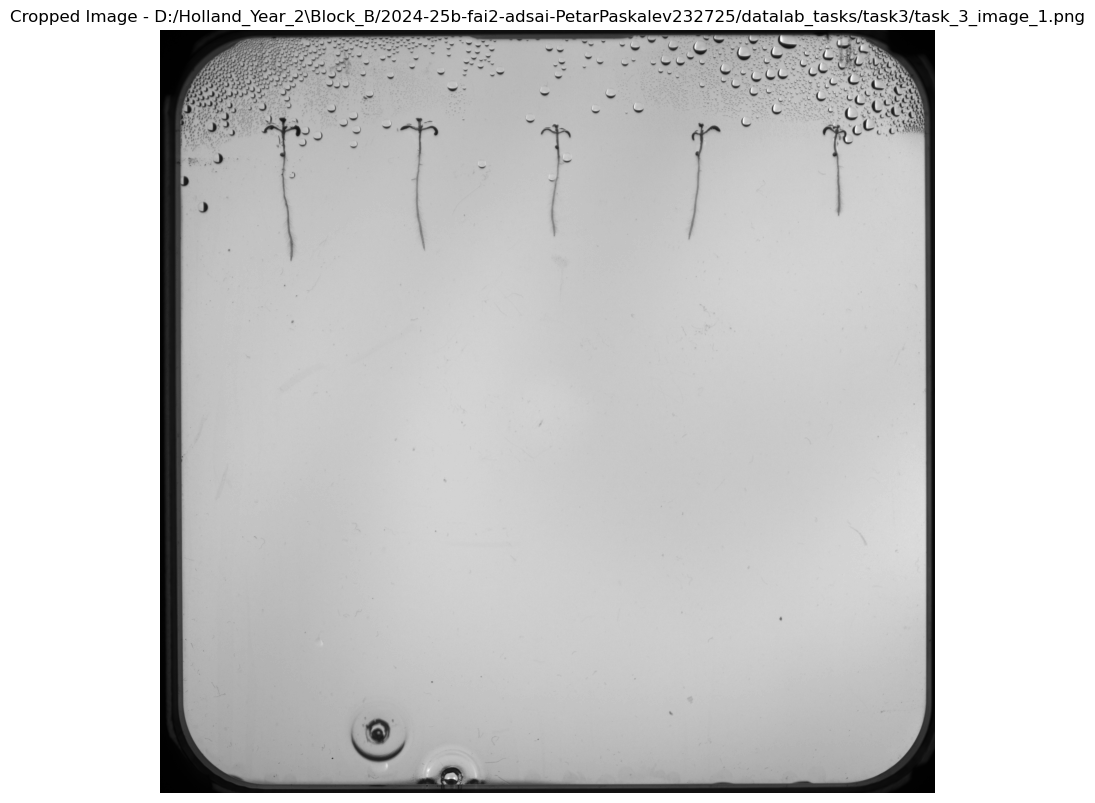

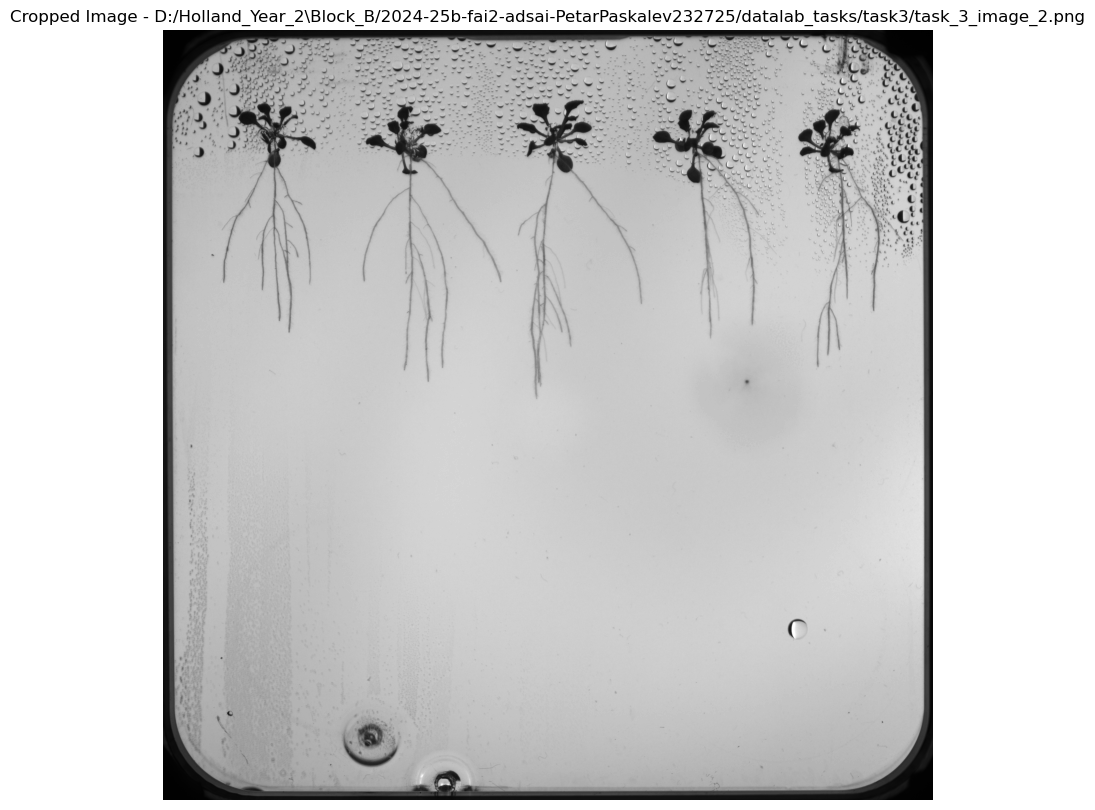

In [27]:
# Load the images and crop based on detected edges
for image_path in image_paths:
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Detect edges and crop the image
    try:
        edges = detect_edges(image)
        cropped_image = crop_image(image, edges)

        # Display the cropped image
        plt.figure(figsize=(10, 10))
        plt.imshow(cropped_image, cmap='gray')
        plt.title(f"Cropped Image - {image_path}")
        plt.axis('off')
        plt.show()

    except ValueError as e:
        print(f"Error during cropping for {image_path}: {e}")


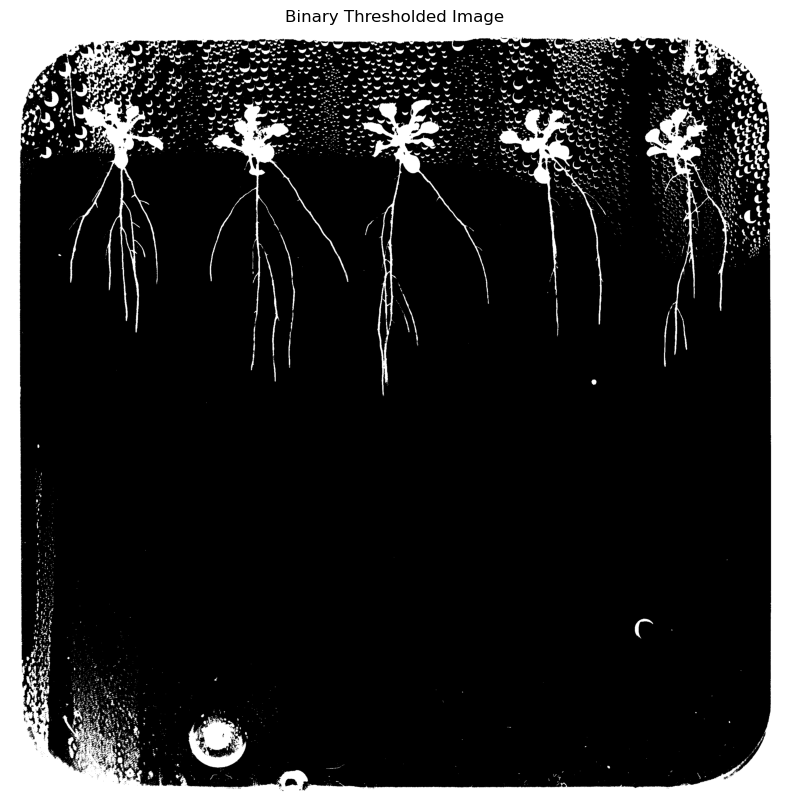

In [ ]:
# Apply binary threshold
_, binary_image = cv2.threshold(cropped_image, 160, 255, cv2.THRESH_BINARY_INV)

# Display the binary thresholded image
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Thresholded Image")
plt.axis('off')
plt.show()


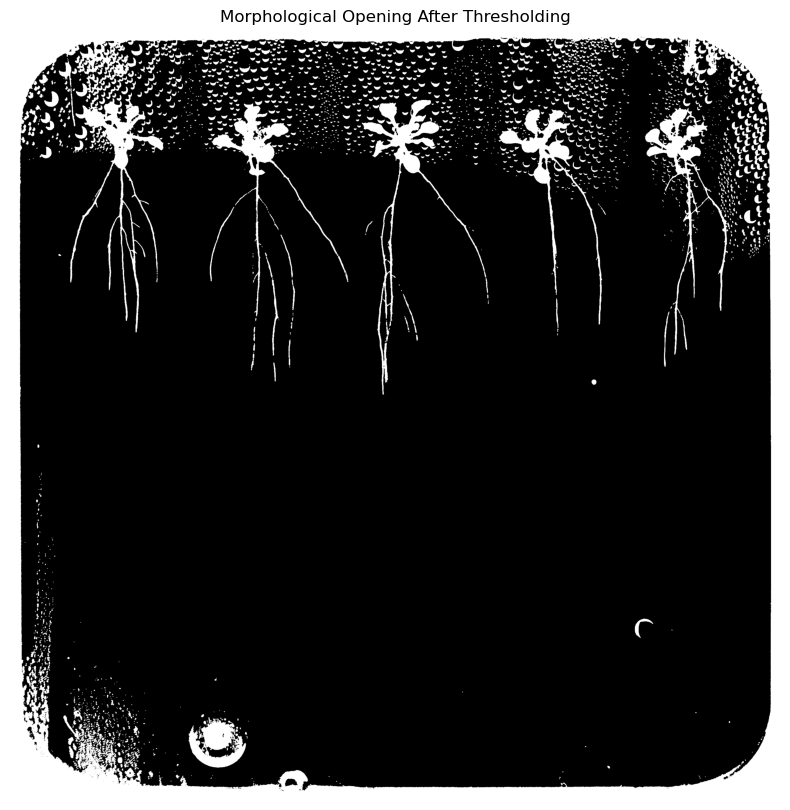

In [29]:
# Apply morphological opening to clean noise and connect components
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Display the result after morphological opening
plt.figure(figsize=(10, 10))
plt.imshow(opened_image, cmap='gray')
plt.title("Morphological Opening After Thresholding")
plt.axis('off')
plt.show()


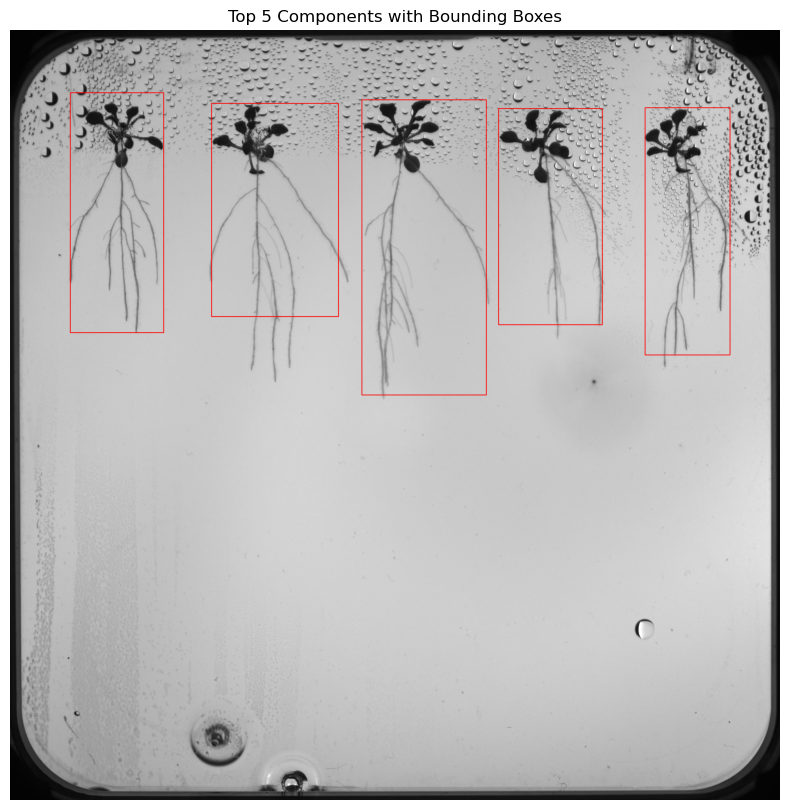

In [31]:
# Exclude the largest component (likely the background) and take the next 5 largest components
top_5_stats = sorted_stats[1:6]  # Exclude the largest and take the next 5

# Convert the original image to BGR for drawing colored bounding boxes
output_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes around the top 5 components
for stat in top_5_stats:
    x = stat[cv2.CC_STAT_LEFT]
    y = stat[cv2.CC_STAT_TOP]
    w = stat[cv2.CC_STAT_WIDTH]
    h = stat[cv2.CC_STAT_HEIGHT]
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box

# Display the final image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Top 5 Components with Bounding Boxes")
plt.axis('off')
plt.show()


C:\Users\35988\AppData\Local\Temp\ipykernel_37644\3590267103.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('viridis', len(top_5_stats))  # Adjust for the number of components (5)


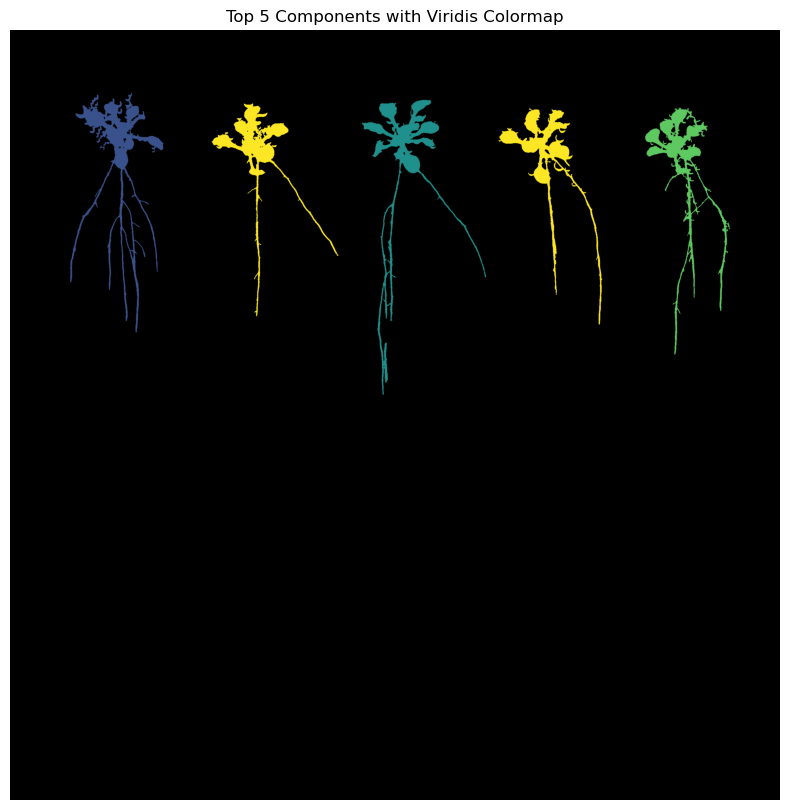

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import cv2

# Step 1: Create a mask for the top 5 components (excluding the largest one)
component_mask = np.zeros_like(labels, dtype=np.uint8)

# Iterate over the indices of the top 5 stats excluding the largest (top_5_stats[1:])
for i, stat in enumerate(top_5_stats):  # Use top_5_stats directly (ensure it includes 5 components)
    # Find the label index corresponding to the current component
    label_idx = np.where((stats[:, cv2.CC_STAT_LEFT] == stat[cv2.CC_STAT_LEFT]) &
                         (stats[:, cv2.CC_STAT_TOP] == stat[cv2.CC_STAT_TOP]) &
                         (stats[:, cv2.CC_STAT_WIDTH] == stat[cv2.CC_STAT_WIDTH]) &
                         (stats[:, cv2.CC_STAT_HEIGHT] == stat[cv2.CC_STAT_HEIGHT]) &
                         (stats[:, cv2.CC_STAT_AREA] == stat[cv2.CC_STAT_AREA]))[0][0]
    
    # Assign a unique value for the component in the mask
    component_mask[labels == label_idx] = i + 1

# Step 2: Apply the Viridis colormap
viridis_cmap = cm.get_cmap('viridis', len(top_5_stats))  # Adjust for the number of components (5)

# Create a blank RGB image
colored_image = np.zeros((component_mask.shape[0], component_mask.shape[1], 3), dtype=np.uint8)

# Map the Viridis colormap colors to each component
for i in range(1, len(top_5_stats) + 1):  # Iterate through 5 components (1 to 5)
    color = (np.array(viridis_cmap(i / len(top_5_stats))[:3]) * 255).astype(np.uint8)  # Viridis color
    colored_image[component_mask == i] = color

# Step 3: Display the output
plt.figure(figsize=(10, 10))
plt.imshow(colored_image)
plt.title("Top 5 Components with Viridis Colormap")
plt.axis('off')
plt.show()
